### Parameter inputs for one-off attempt

In [184]:
crop = "Rice"
month = 8
crop_features=["_Weighted_Rainfall", "_Weighted_VHI", "_Weighted_VHI_Cumulative", "_Weighted_Temperature"]
universal_features=[]
features = crop_features + universal_features
training_data_years = 20
differencing=1
ma=0
year = 2020
max_year = 2024
min_year = 1995
target="Production"
crops = ["Rice", "Corn", "Millet", "Sorghum", "Peanut"]
model_features = features
model_parameters = {
    "training_data_years": training_data_years,
    "differencing": differencing,
    "ma": ma,
}

crop_features_named = [crop + feature for feature in crop_features]
all_features = crop_features_named + universal_features
all_features_with_target = all_features + [target]

In [185]:
import pandas as pd

def load_month_data_and_filter_for_crop_and_features(month, crop, all_features_with_target):
    data = pd.read_csv(f"processed_data/final_data/final_data_{month}.csv")

    # Filter for just the crop
    data = data[data["Crop"] == crop]

    # Select relevant columns
    df = data.loc[:, ["Year", "Production"] + universal_features]

    for feature in all_features_with_target:
        if differencing > 0:
            df.loc[:, f"{feature}_Transformed"] = data[feature].diff(differencing)
        else:
            df.loc[:, f"{feature}_Transformed"] = data[feature]
        
        if ma > 0:
            df.loc[:, f"{feature}_Transformed"] = data[feature].rolling(ma).mean()

    # Add Production_PY as a column
    df.loc[:, "Production_PY"] = df["Production"].shift(1)

    return df

df = load_month_data_and_filter_for_crop_and_features(month, crop, all_features_with_target)
df.tail()

,Year,Production,Rice_Weighted_Rainfall_Transformed,Rice_Weighted_VHI_Transformed,Rice_Weighted_VHI_Cumulative_Transformed,Rice_Weighted_Temperature_Transformed,Production_Transformed,Production_PY
128,2020,1349723.01,232.59442,0.229853,-0.10783,0.646786,193992.73,1155730.28
133,2021,1382119.93,-75.98647,-0.100917,1.72054,-0.628034,32396.92,1349723.01
138,2022,1409120.00,126.22800,0.129442,1.32303,0.188171,27000.07,1382119.93
143,2023,1521000.00,-181.48462,-0.005472,-0.45262,0.332371,111880.00,1409120.00
148,2024,1521000.00,3.76221,-0.033207,-2.28014,0.183561,0.00,1521000.00


In [186]:
# Add _Transformed to all_features_with_target names
all_features_with_target_transformed = [feature + "_Transformed" for feature in all_features_with_target]
all_features_transformed = [feature + "_Transformed" for feature in all_features]
target_transformed = target + "_Transformed"

df[all_features_with_target_transformed].corr()

,Rice_Weighted_Rainfall_Transformed,Rice_Weighted_VHI_Transformed,Rice_Weighted_VHI_Cumulative_Transformed,Rice_Weighted_Temperature_Transformed,Production_Transformed
Rice_Weighted_Rainfall_Transformed,1.000000,0.691878,0.284278,-0.280719,0.479519
Rice_Weighted_VHI_Transformed,0.691878,1.000000,0.464443,-0.185735,0.496970
Rice_Weighted_VHI_Cumulative_Transformed,0.284278,0.464443,1.000000,0.034490,0.165413
Rice_Weighted_Temperature_Transformed,-0.280719,-0.185735,0.034490,1.000000,-0.054778
Production_Transformed,0.479519,0.496970,0.165413,-0.054778,1.000000


In [187]:
def split_into_testing_and_training(df, year, training_data_years):
    # Training data should be less than year but greater than year - training_data_years
    df["YearFeature"] = df["Year"]
    
    train = df[(df["Year"] < year) & (df["Year"] >= (year - training_data_years))]
    test = df[df["Year"] == year]

    X_train = train[all_features_transformed + ["YearFeature"]]
    y_train = train[target_transformed]

    X_test = test[all_features_transformed + ["YearFeature"]]
    y_test = test[target_transformed]

    return X_train, y_train, X_test, y_test, train, test

X_train, y_train, X_test, y_test, train, test = split_into_testing_and_training(df, year, training_data_years)

X_train.head()

,Rice_Weighted_Rainfall_Transformed,Rice_Weighted_VHI_Transformed,Rice_Weighted_VHI_Cumulative_Transformed,Rice_Weighted_Temperature_Transformed,YearFeature
28,-91.44482,-0.264740,-0.81456,1.084301,2000
33,16.86868,0.047203,-1.81693,1.108100,2001
38,-57.19656,-0.242113,-2.15068,-7.973036,2002
43,63.02008,0.172553,0.29682,2.300695,2003
48,55.16771,0.027997,3.37080,3.890713,2004


In [188]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

model_type = "lr all vars - inc 2024"

def train_model(X_train, y_train):
    model = LinearRegression()
    model = model.fit(X_train, y_train)
    return model

model = train_model(X_train, y_train)

In [189]:
def get_test_prediction(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_pred_val = y_pred[0]

    return y_pred_val

y_pred = get_test_prediction(model, X_test, y_test)
y_pred

380509.52738558874

In [190]:
def transform_back_and_reverse_differencing_and_ma(y_pred_val, y_test, differencing, ma, train, test):
    y_pred_transformed = y_pred_val
    y_test_transformed = y_test

    # Reverse the differencing and ma if used
    if differencing > 0:
        y_pred_transformed = y_pred_transformed + test["Production_PY"].iloc[-1]
        y_test_transformed = y_test_transformed + test["Production_PY"].iloc[-1]

    if ma > 0:
        y_pred_transformed = y_pred_transformed + test["Production_PY"].rolling(ma).mean().iloc[-1]
        y_test_transformed = y_test_transformed + test["Production_PY"].rolling(ma).mean().iloc[-1]

    # OVERWRITE FOR BASELINE
    # y_pred_transformed = test["Production_PY"].iloc[-1]

    return y_pred_transformed, y_test_transformed

y_pred_transformed, y_test_transformed = transform_back_and_reverse_differencing_and_ma(y_pred, y_test, differencing, ma, train, test)
y_pred_transformed, y_test_transformed

(1536239.8073855888,
 128    1349723.01
 Name: Production_Transformed, dtype: float64)

In [191]:
rainfall_2024 = 50
vhi_2024 = 0.5
vhi_cumulative_2024 = 0.5
temperature_2024 = 20


y_pred = get_test_prediction(model, X_test, y_test)
y_pred

380509.52738558874

In [192]:
def train_and_test_model_for_one_year_and_crop(year, crop):
    df = load_month_data_and_filter_for_crop_and_features(month, crop, all_features_with_target)
    X_train, y_train, X_test, y_test, train, test = split_into_testing_and_training(df, year, training_data_years)
    model = train_model(X_train, y_train)
    y_pred = get_test_prediction(model, X_test, y_test)
    y_pred_transformed, y_test_transformed = transform_back_and_reverse_differencing_and_ma(y_pred, y_test, differencing, ma, train, test)

    # Calculate error and pct error
    error = y_pred_transformed - y_test_transformed
    pct_error = error / y_test_transformed
    return crop, year, month, model_type, model_features, model_parameters, y_pred_transformed, y_test_transformed, error, pct_error

crop, year, month, model_type, model_features, model_parameters, y_pred_transformed, y_test_transformed, error, pct_error = train_and_test_model_for_one_year_and_crop(year, crop)

# Print out all results
print(f"Crop: {crop}")
print(f"Prediction Year: {year}")
print(f"Month in which prediction is made: {month}")
print(f"Model: {model_type}")
print(f"Features: {model_features}")
print(f"Parameters: {model_parameters}")
print(f"Predicted Production: {y_pred_transformed}")
print(f"Actual Production: {y_test_transformed.values}")
print(f"Error: {error.values}")
print(f"% Error: {pct_error.values}")

Crop: Rice
Prediction Year: 2020
Month in which prediction is made: 8
Model: lr all vars - inc 2024
Features: ['_Weighted_Rainfall', '_Weighted_VHI', '_Weighted_VHI_Cumulative', '_Weighted_Temperature']
Parameters: {'training_data_years': 20, 'differencing': 1, 'ma': 0}
Predicted Production: 1536239.8073855888
Actual Production: [1349723.01]
Error: [186516.79738559]
% Error: [0.13818894]


In [193]:
def run_model_across_crops_and_years(crops, min_year, max_year, training_data_years, month, model_type, model_features, model_parameters):

    # For every crop and every year from max_year - training_data_years to max_year, train and test the model and save results in a results dataframe
    results = pd.DataFrame(columns=["Crop", "Year", "Month", "Model", "Features", "Parameters", "Predicted Production", "Actual Production", "Error", "% Error"])

    for year in range(2017, max_year+1):
        for crop in crops:
            print(f"running for year: {year} and for crop: {crop}")
            crop, year, month, model_type, model_features, model_parameters, y_pred_transformed, y_test_transformed, error, pct_error = train_and_test_model_for_one_year_and_crop(year, crop)
            # Get the feature names and their values for the test example
            test_features_values = X_test.iloc[0]
            
            # Create a DataFrame for the current iteration's results
            result_df = pd.DataFrame({
                "Crop": [crop],
                "Year": [year],
                "Month": [month],
                "Model": [model_type],
                "Features": [model_features],
                "Feature Values": [test_features_values],
                "Parameters": [model_parameters],
                "Predicted Production": [y_pred_transformed],
                "Actual Production": [y_test_transformed.values[0]],
                "Error": [error.values[0]],
                "% Error": [pct_error.values[0]]
            })
            
            # Concatenate the current result with the overall results DataFrame
            results = pd.concat([results, result_df], ignore_index=True)
    
    return results

# Run the function and get the results
results = run_model_across_crops_and_years(crops, min_year, max_year, training_data_years, month, model_type, model_features, model_parameters)

running for year: 2017 and for crop: Rice
running for year: 2017 and for crop: Corn
running for year: 2017 and for crop: Millet
running for year: 2017 and for crop: Sorghum
running for year: 2017 and for crop: Peanut
running for year: 2018 and for crop: Rice
running for year: 2018 and for crop: Corn
running for year: 2018 and for crop: Millet
running for year: 2018 and for crop: Sorghum
running for year: 2018 and for crop: Peanut
running for year: 2019 and for crop: Rice
running for year: 2019 and for crop: Corn

C:\Users\mikej\AppData\Local\Temp\ipykernel_27968\1579538601.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result_df], ignore_index=True)



running for year: 2019 and for crop: Millet
running for year: 2019 and for crop: Sorghum
running for year: 2019 and for crop: Peanut
running for year: 2020 and for crop: Rice
running for year: 2020 and for crop: Corn
running for year: 2020 and for crop: Millet
running for year: 2020 and for crop: Sorghum
running for year: 2020 and for crop: Peanut
running for year: 2021 and for crop: Rice
running for year: 2021 and for crop: Corn
running for year: 2021 and for crop: Millet
running for year: 2021 and for crop: Sorghum
running for year: 2021 and for crop: Peanut
running for year: 2022 and for crop: Rice
running for year: 2022 and for crop: Corn
running for year: 2022 and for crop: Millet
running for year: 2022 and for crop: Sorghum
running for year: 2022 and for crop: Peanut
running for year: 2023 and for crop: Rice
running for year: 2023 and for crop: Corn
running for year: 2023 and for crop: Millet
running for year: 2023 and for crop: Sorghum
running for year: 2023 and for crop: Peanu

In [194]:
def calculate_error_metrics(results):
    results["Abs_Error"] = results["Error"].abs()
    results["Abs_Pct_Error"] = results["% Error"].abs()

    # Print out the mean absolute error
    print(f"Mean Absolute Error: {results['Abs_Error'].mean()}")

    # Print out the mean absolute percent error
    print(f"Mean Absolute Percent Error: {results['Abs_Pct_Error'].mean()}")
    
    return results

results = calculate_error_metrics(results)

Mean Absolute Error: 132588.78697869251
Mean Absolute Percent Error: 0.12664890707213952


### Add results to log file

In [195]:
import datetime
import csv

def log_summary_and_save_results_to_csv(results, save_csv=True, run_id=None):
    # Create a dictionary to hold the log data
    log_data = {}
    
    # Bring in Crop, Year, Month, Model, and Features from the results DataFrame
    log_data["ID"] = run_id
    log_data["Month"] = results['Month'][0]
    log_data["Model"] = results['Model'][0]
    log_data["Features"] = results['Features'][0]
    
    # Calculate overall metrics and add them to the log data
    log_data["MAPE"] = results["Abs_Pct_Error"].mean()
    log_data["MAE"] = results["Abs_Error"].mean()
    log_data["Timestamp"] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    

    # Calculate MAPE for each crop and add to the log data
    crop_mape = results.groupby("Crop")["Abs_Pct_Error"].mean()
    for crop, mape in crop_mape.items():
        log_data[f"{crop}_MAPE"] = mape

    # Calculate MAPE for each year and add to the log data
    year_mape = results.groupby("Year")["Abs_Pct_Error"].mean()
    for year, mape in year_mape.items():
        log_data[f"{year}_MAPE"] = mape

    log_data["Paarameters"] = results["Parameters"][0]

    # Specify the log file path
    log_file_path = "results_log.csv"

    # Check if the file already exists
    file_exists = False
    try:
        with open(log_file_path, "r"):
            file_exists = True
    except FileNotFoundError:
        pass

    # Write the log data to the CSV file
    with open(log_file_path, mode="a", newline='') as log_file:
        writer = csv.DictWriter(log_file, fieldnames=log_data.keys())

        # Write the header only if the file does not already exist
        if not file_exists:
            writer.writeheader()

        # Write the log data as a new row
        writer.writerow(log_data)

    # Save the full results to a timestamped CSV file
    if save_csv:
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        results.to_csv(f"results/results_{timestamp}.csv", index=False)

    # Confirm that logging is complete
    print("Logging completed")

# Example usage
# log_summary_and_save_results_to_csv(results, save_csv=False)

In [196]:
def run_model_and_log_results(crops, min_year, max_year, training_data_years, month, model_type, model_features, model_parameters, save_csv=True, run_id=None):
    results = run_model_across_crops_and_years(crops, min_year, max_year, training_data_years, month, model_type, model_features, model_parameters)
    results = calculate_error_metrics(results)
    log_summary_and_save_results_to_csv(results, save_csv, run_id)
    return results

# For one example
# run_model_and_log_results(crops, min_year, max_year, training_data_years, month, model_type, model_features, model_parameters, save_csv=False)

In [199]:
# For all months
# Create blank results to append to
# Import random
import random

results_combined = pd.DataFrame(columns=["ID", "Year", "Month", "Model", "Features", "Parameters", "Predicted Production", "Actual Production", "Error", "% Error"])

# Randomly generate an 8 digit number
run_id = random.randint(10000000, 99999999)

for month in range(1, 9):
    results = run_model_and_log_results(crops, min_year, max_year, training_data_years, month, model_type, model_features, model_parameters, False, run_id)
    # Append results
    results_combined = pd.concat([results_combined, results], ignore_index=True)

# Save results to csv with a timestamp
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_combined.to_csv(f"results/all_results-{timestamp}.csv", index=False)

running for year: 2017 and for crop: Rice
running for year: 2017 and for crop: Corn
running for year: 2017 and for crop: Millet
running for year: 2017 and for crop: Sorghum
running for year: 2017 and for crop: Peanut
running for year: 2018 and for crop: Rice
running for year: 2018 and for crop: Corn
running for year: 2018 and for crop: Millet


C:\Users\mikej\AppData\Local\Temp\ipykernel_27968\1579538601.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result_df], ignore_index=True)


running for year: 2018 and for crop: Sorghum
running for year: 2018 and for crop: Peanut
running for year: 2019 and for crop: Rice
running for year: 2019 and for crop: Corn
running for year: 2019 and for crop: Millet
running for year: 2019 and for crop: Sorghum
running for year: 2019 and for crop: Peanut
running for year: 2020 and for crop: Rice
running for year: 2020 and for crop: Corn
running for year: 2020 and for crop: Millet
running for year: 2020 and for crop: Sorghum
running for year: 2020 and for crop: Peanut
running for year: 2021 and for crop: Rice
running for year: 2021 and for crop: Corn
running for year: 2021 and for crop: Millet
running for year: 2021 and for crop: Sorghum
running for year: 2021 and for crop: Peanut
running for year: 2022 and for crop: Rice
running for year: 2022 and for crop: Corn
running for year: 2022 and for crop: Millet
running for year: 2022 and for crop: Sorghum
running for year: 2022 and for crop: Peanut
running for year: 2023 and for crop: Rice
r

C:\Users\mikej\AppData\Local\Temp\ipykernel_27968\640204435.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_combined = pd.concat([results_combined, results], ignore_index=True)
C:\Users\mikej\AppData\Local\Temp\ipykernel_27968\1579538601.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result_df], ignore_index=True)


running for year: 2017 and for crop: Millet
running for year: 2017 and for crop: Sorghum
running for year: 2017 and for crop: Peanut
running for year: 2018 and for crop: Rice
running for year: 2018 and for crop: Corn
running for year: 2018 and for crop: Millet
running for year: 2018 and for crop: Sorghum
running for year: 2018 and for crop: Peanut
running for year: 2019 and for crop: Rice
running for year: 2019 and for crop: Corn
running for year: 2019 and for crop: Millet
running for year: 2019 and for crop: Sorghum
running for year: 2019 and for crop: Peanut
running for year: 2020 and for crop: Rice
running for year: 2020 and for crop: Corn
running for year: 2020 and for crop: Millet
running for year: 2020 and for crop: Sorghum
running for year: 2020 and for crop: Peanut
running for year: 2021 and for crop: Rice
running for year: 2021 and for crop: Corn
running for year: 2021 and for crop: Millet
running for year: 2021 and for crop: Sorghum
running for year: 2021 and for crop: Peanut

C:\Users\mikej\AppData\Local\Temp\ipykernel_27968\1579538601.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result_df], ignore_index=True)


running for year: 2018 and for crop: Millet
running for year: 2018 and for crop: Sorghum
running for year: 2018 and for crop: Peanut
running for year: 2019 and for crop: Rice
running for year: 2019 and for crop: Corn
running for year: 2019 and for crop: Millet
running for year: 2019 and for crop: Sorghum
running for year: 2019 and for crop: Peanut
running for year: 2020 and for crop: Rice
running for year: 2020 and for crop: Corn
running for year: 2020 and for crop: Millet
running for year: 2020 and for crop: Sorghum
running for year: 2020 and for crop: Peanut
running for year: 2021 and for crop: Rice
running for year: 2021 and for crop: Corn
running for year: 2021 and for crop: Millet
running for year: 2021 and for crop: Sorghum
running for year: 2021 and for crop: Peanut
running for year: 2022 and for crop: Rice
running for year: 2022 and for crop: Corn
running for year: 2022 and for crop: Millet
running for year: 2022 and for crop: Sorghum
running for year: 2022 and for crop: Peanut

C:\Users\mikej\AppData\Local\Temp\ipykernel_27968\1579538601.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result_df], ignore_index=True)


running for year: 2018 and for crop: Millet
running for year: 2018 and for crop: Sorghum
running for year: 2018 and for crop: Peanut
running for year: 2019 and for crop: Rice
running for year: 2019 and for crop: Corn
running for year: 2019 and for crop: Millet
running for year: 2019 and for crop: Sorghum
running for year: 2019 and for crop: Peanut
running for year: 2020 and for crop: Rice
running for year: 2020 and for crop: Corn
running for year: 2020 and for crop: Millet
running for year: 2020 and for crop: Sorghum
running for year: 2020 and for crop: Peanut
running for year: 2021 and for crop: Rice
running for year: 2021 and for crop: Corn
running for year: 2021 and for crop: Millet
running for year: 2021 and for crop: Sorghum
running for year: 2021 and for crop: Peanut
running for year: 2022 and for crop: Rice
running for year: 2022 and for crop: Corn
running for year: 2022 and for crop: Millet
running for year: 2022 and for crop: Sorghum
running for year: 2022 and for crop: Peanut

C:\Users\mikej\AppData\Local\Temp\ipykernel_27968\1579538601.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result_df], ignore_index=True)


running for year: 2019 and for crop: Rice
running for year: 2019 and for crop: Corn
running for year: 2019 and for crop: Millet
running for year: 2019 and for crop: Sorghum
running for year: 2019 and for crop: Peanut
running for year: 2020 and for crop: Rice
running for year: 2020 and for crop: Corn
running for year: 2020 and for crop: Millet
running for year: 2020 and for crop: Sorghum
running for year: 2020 and for crop: Peanut
running for year: 2021 and for crop: Rice
running for year: 2021 and for crop: Corn
running for year: 2021 and for crop: Millet
running for year: 2021 and for crop: Sorghum
running for year: 2021 and for crop: Peanut
running for year: 2022 and for crop: Rice
running for year: 2022 and for crop: Corn
running for year: 2022 and for crop: Millet
running for year: 2022 and for crop: Sorghum
running for year: 2022 and for crop: Peanut
running for year: 2023 and for crop: Rice
running for year: 2023 and for crop: Corn
running for year: 2023 and for crop: Millet
runn

C:\Users\mikej\AppData\Local\Temp\ipykernel_27968\1579538601.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result_df], ignore_index=True)


running for year: 2018 and for crop: Millet
running for year: 2018 and for crop: Sorghum
running for year: 2018 and for crop: Peanut
running for year: 2019 and for crop: Rice
running for year: 2019 and for crop: Corn
running for year: 2019 and for crop: Millet
running for year: 2019 and for crop: Sorghum
running for year: 2019 and for crop: Peanut
running for year: 2020 and for crop: Rice
running for year: 2020 and for crop: Corn
running for year: 2020 and for crop: Millet
running for year: 2020 and for crop: Sorghum
running for year: 2020 and for crop: Peanut
running for year: 2021 and for crop: Rice
running for year: 2021 and for crop: Corn
running for year: 2021 and for crop: Millet
running for year: 2021 and for crop: Sorghum
running for year: 2021 and for crop: Peanut
running for year: 2022 and for crop: Rice
running for year: 2022 and for crop: Corn
running for year: 2022 and for crop: Millet
running for year: 2022 and for crop: Sorghum
running for year: 2022 and for crop: Peanut

C:\Users\mikej\AppData\Local\Temp\ipykernel_27968\1579538601.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result_df], ignore_index=True)


running for year: 2018 and for crop: Corn
running for year: 2018 and for crop: Millet
running for year: 2018 and for crop: Sorghum
running for year: 2018 and for crop: Peanut
running for year: 2019 and for crop: Rice
running for year: 2019 and for crop: Corn
running for year: 2019 and for crop: Millet
running for year: 2019 and for crop: Sorghum
running for year: 2019 and for crop: Peanut
running for year: 2020 and for crop: Rice
running for year: 2020 and for crop: Corn
running for year: 2020 and for crop: Millet
running for year: 2020 and for crop: Sorghum
running for year: 2020 and for crop: Peanut
running for year: 2021 and for crop: Rice
running for year: 2021 and for crop: Corn
running for year: 2021 and for crop: Millet
running for year: 2021 and for crop: Sorghum
running for year: 2021 and for crop: Peanut
running for year: 2022 and for crop: Rice
running for year: 2022 and for crop: Corn
running for year: 2022 and for crop: Millet
running for year: 2022 and for crop: Sorghum
r

C:\Users\mikej\AppData\Local\Temp\ipykernel_27968\1579538601.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result_df], ignore_index=True)


running for year: 2018 and for crop: Millet
running for year: 2018 and for crop: Sorghum
running for year: 2018 and for crop: Peanut
running for year: 2019 and for crop: Rice
running for year: 2019 and for crop: Corn
running for year: 2019 and for crop: Millet
running for year: 2019 and for crop: Sorghum
running for year: 2019 and for crop: Peanut
running for year: 2020 and for crop: Rice
running for year: 2020 and for crop: Corn
running for year: 2020 and for crop: Millet
running for year: 2020 and for crop: Sorghum
running for year: 2020 and for crop: Peanut
running for year: 2021 and for crop: Rice
running for year: 2021 and for crop: Corn
running for year: 2021 and for crop: Millet
running for year: 2021 and for crop: Sorghum
running for year: 2021 and for crop: Peanut
running for year: 2022 and for crop: Rice
running for year: 2022 and for crop: Corn
running for year: 2022 and for crop: Millet
running for year: 2022 and for crop: Sorghum
running for year: 2022 and for crop: Peanut

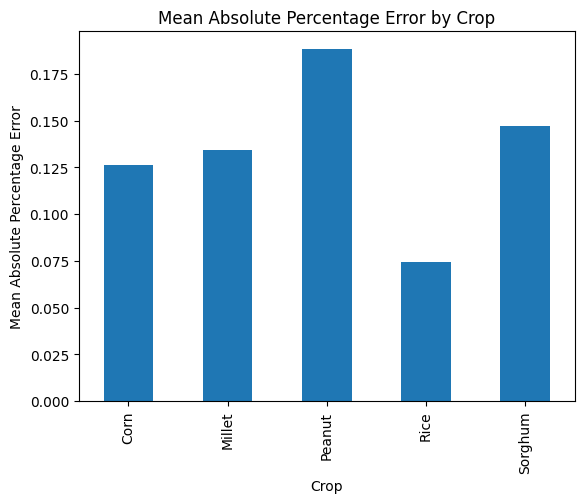

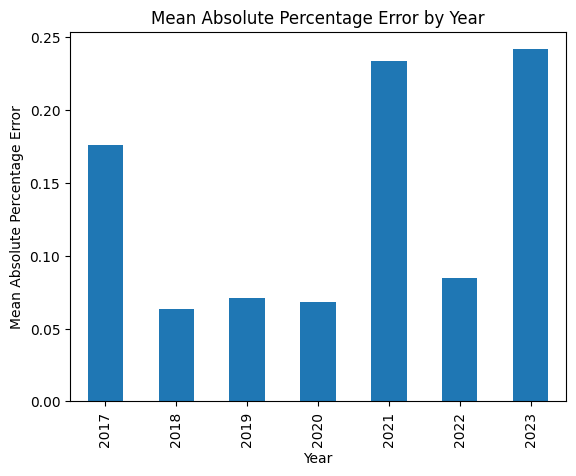

In [ ]:
# Create a chart with the MAPE for each crop, make sure to include labels on the columns
import matplotlib.pyplot as plt

results.groupby("Crop")["Abs_Pct_Error"].mean().plot(kind="bar")
plt.ylabel("Mean Absolute Percentage Error")
plt.title("Mean Absolute Percentage Error by Crop")
plt.show()

# And by year
results.groupby("Year")["Abs_Pct_Error"].mean().plot(kind="bar")
plt.ylabel("Mean Absolute Percentage Error")
plt.title("Mean Absolute Percentage Error by Year")
plt.show()

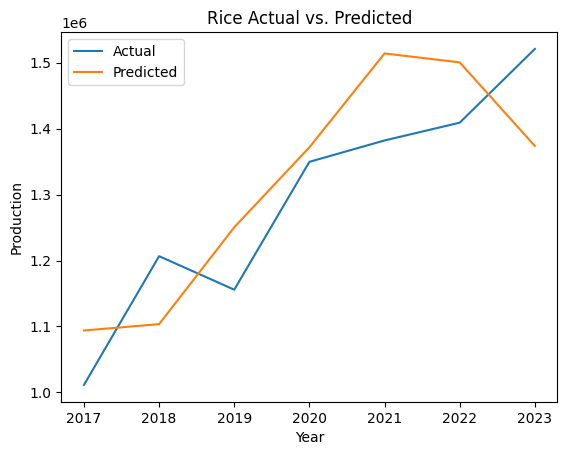

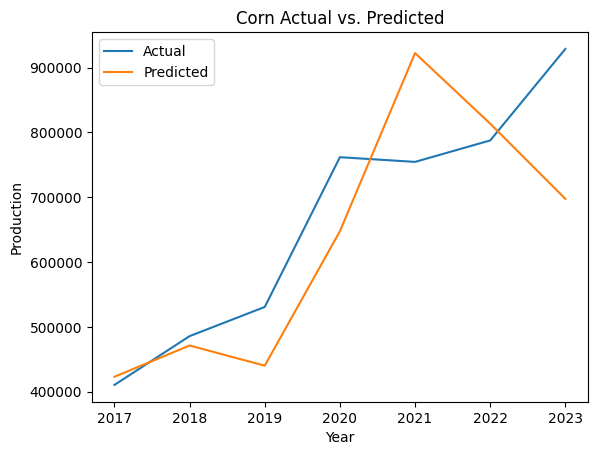

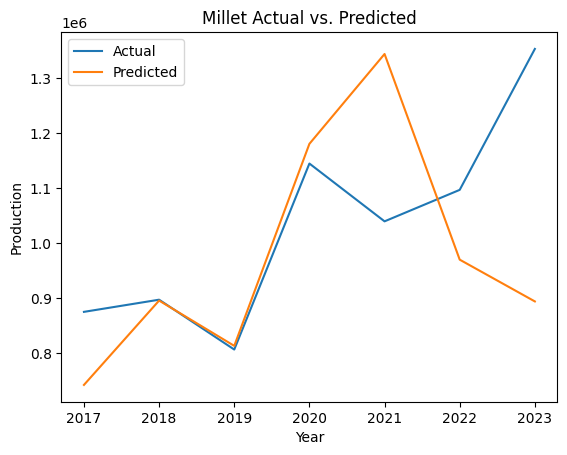

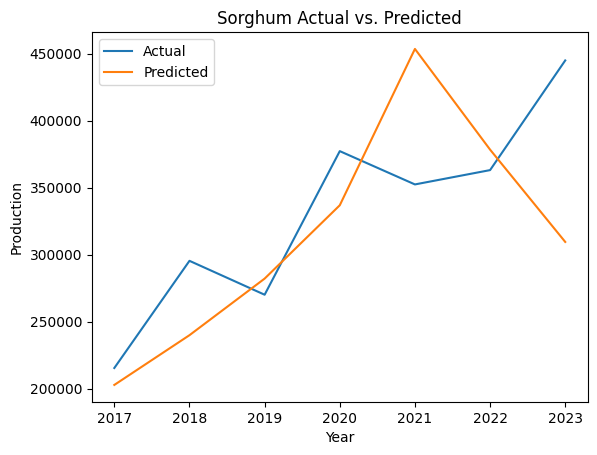

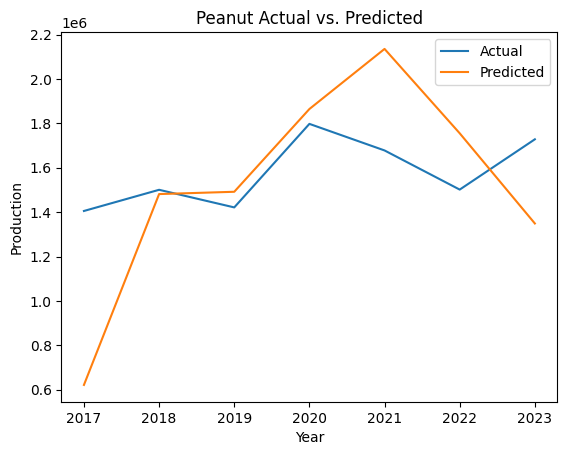

In [ ]:
# Line chart of the actuals vs. predicted, one for each crop. Over all years
for crop in crops:
    crop_results = results[results["Crop"] == crop]
    plt.plot(crop_results["Year"], crop_results["Actual Production"], label="Actual")
    plt.plot(crop_results["Year"], crop_results["Predicted Production"], label="Predicted")
    plt.title(f"{crop} Actual vs. Predicted")
    plt.xlabel("Year")
    plt.ylabel("Production")
    plt.legend()
    plt.show()